In [1]:
package 'Structure'{
    import ScalarValues::*;
    
    item def Data;
    item def 'Ground Station Ping';
    
    package 'Interfaces'{ 
        port def CommunicationInterface {
            out item data : Data; 
            in item ping : 'Ground Station Ping';
        }
        
        interface def CommunicationLink {
            end groundPort : CommunicationInterface;
            end spacePort : CommunicationInterface;
            flow spacePort.data to groundPort.data;
            flow groundPort.ping to spacePort.ping;
        }
    }
    
    
    part def 'Mission'{ //Mission is made of 2 parts, communicating via CommunicationLink
        
        part groundStation : 'Ground Station' {
            port groundCommIF redefines CommIF;
        }
        
        part spacecraftVehicle : 'Spacecraft Vehicle'{
            port spaceCommIF redefines CommIF1;
        }
        
        interface : Interfaces::CommunicationLink connect
            groundPort ::> groundStation.groundCommIF to 
            spacePort ::> spacecraftVehicle.spaceCommIF; 
    }
    

    
    part def 'Ground Station'{
        port CommIF : ~Interfaces::CommunicationInterface;
        
        item def 'Start Signal';
        
        action def PingSpacecraft {
            send 'Ground Station Ping'() via CommIF;
        } 
        
        
        action def ReceiveData {

            first start;
            then merge repeat;
            
            then action trigger accept Data {
                out item dataFrame : Data;
            }
            
            flow trigger.dataFrame to processData.dataFrame;
            
            then action processData {
                in item dataFrame : Data;
            }
            
            then repeat;
        }
        
        
        exhibit state groundStationModes {

            entry action initial; then idle;
            state idle;
            
            state operation {
                entry action : PingSpacecraft;
                do action : ReceiveData;
            }
            
            transition 'idle-operation'
                first idle
                accept after 30[SI::s]
                then operation;
            transition 'idle-operation_2'
                first idle
                accept 'Start Signal'
                then operation;
            
            transition 'operation-idle'
                first operation
                accept 'Spacecraft Vehicle'::'Shut Down Signal'
                then idle;
        }
    }
    
    part def 'Spacecraft Vehicle'{
        port CommIF1 : Interfaces::CommunicationInterface;
        ref gs : 'Ground Station';
       
        item def 'Battery Fully Charged';
        item def 'Shut Down Signal';
        item def 'Battery Low';
        item def 'Transmission Done Signal';
        
        attribute data : Real = 102400;
        attribute battery : Real = 100;
        attribute transmissionInProgress : Boolean = false;
        attribute t0 : Real = 0;
        attribute tfinal : Real = 0;

        action def ConsumePower {
            // 0. in case trigger:DeviceOff => "stop action"
            // 1. merge node
            // 2. battery--;
            // 3a. case battery <40 : send signal 'Battery Low' to TransmitData process
            // 3b. case battery >40 : flow to merge node 1.

            inout battery : Real;
            
            action shutDown accept shutDownSignal : 'Shut Down Signal';
            then done; 
            
            merge repeat;
            then action dechargeBattery { battery = battery - 1; }
            then decide;
                if battery >= 40 then repeat;
                else sendBatteryLow;
            
            action sendBatteryLow send 'Battery Low'() to self;
        }

        
        action def RechargeBatteries {
            // 1. merge node
            // 2a. case battery >=100 : send signal 'Battery fully charged' then stop action
            // 2b. case battery <100 : battery++; then flow to merge node 1
            inout battery : Real;
            
            first start;
            then merge mergeNode;
            
            then decide;
                if battery >= 100 then sendCharged;
                else chargeBattery;
            
            action chargeBattery { battery = battery + 1; }
            then mergeNode;
            
            action sendCharged send 'Battery Fully Charged'() to self;
            then done;
        }
        
        action def SendDataFrames {
            // 1. data = data-1024;
            // 2. send DataPacket on CommunicationInterface to Ground Station 
            inout data : Real;
            
            first start;
            
            fork parallelStart;
                then datasub;
                then sendDataPacket;
            
            action datasub { data = data - 1024; }
            then parallelEnd;
            action sendDataPacket { send Data() via CommIF1; }
            then parallelEnd;
            
            join parallelEnd;
            then done;
            
        }
        

        action def TransmitData {
            inout data : Real;
            // 00 trigger "battery low" : go to 6.Merge
            // 1. run small Javascript Expression
            // 2. Fork (consume power + the following)
            // 3. Merge
            // 4. Decision
            // 5. Case data>0 : sendDataFrames() then go back to 3.Merge
            // 5. Case data=0 : Javascript expression
            // 6. Merge 
            // 7. Send signal Device Off to action ConsumePower
            // 8. Send signal Transmission Done  
            
            first start;
            then action js_1 { /* javascript expression set t_initial */ }
            
            then fork fork1;
                then consumePower;
                then repeat;
                
            merge repeat;
            then decide;
                if data > 0 then sendDataFrames;
                else js_2;
                
            action js_2 { /* javascript expression : t_final transmission done  */ }
            then merge mergeNode_2;
            
            then send 'Shut Down Signal'() to gs;
            then send 'Transmission Done Signal'() to self;
            
            action consumePower : ConsumePower;
            
            action sendDataFrames : SendDataFrames;
            then repeat;
            
            action batteryLow accept batteryLowSignal : 'Battery Low';
            then mergeNode_2;
        }
        
        exhibit state spacecraftModes {
            
            state dataTransit {
                entry action initial; then waitingGSPing;
                
                state waitingGSPing;
                transition 'waitingGSPing-transmitting'
                    first waitingGSPing
                    accept 'Ground Station Ping' // if inState not recharging? // no notation yet
                    then transmitting;
                
                state transmitting{
                    do action : TransmitData;
                }
                
                transition 'transmitting-waitingGSPing'
                    first transmitting
                    accept 'Transmission Done Signal'
                    then waitingGSPing;
                transition 'transmitting-waitingGSPing_2'
                    first transmitting
                    accept 'Battery Low'
                    then waitingGSPing;
            }
            
            state charging{
                entry action initial; then notRecharging;
                
                state notRecharging;
                transition 'notRecharging-charging'
                    first notRecharging
                    accept when battery < 80
                    then recharging;
                state recharging{
                    do action : RechargeBatteries;
                }
                transition 'charging-notRecharging'
                    first charging
                    accept 'Battery Fully Charged'
                    then notRecharging;
            }
        }
    }

}

Package Structure (c3e7f843-b605-48fb-b06c-d1ccc5be334d)


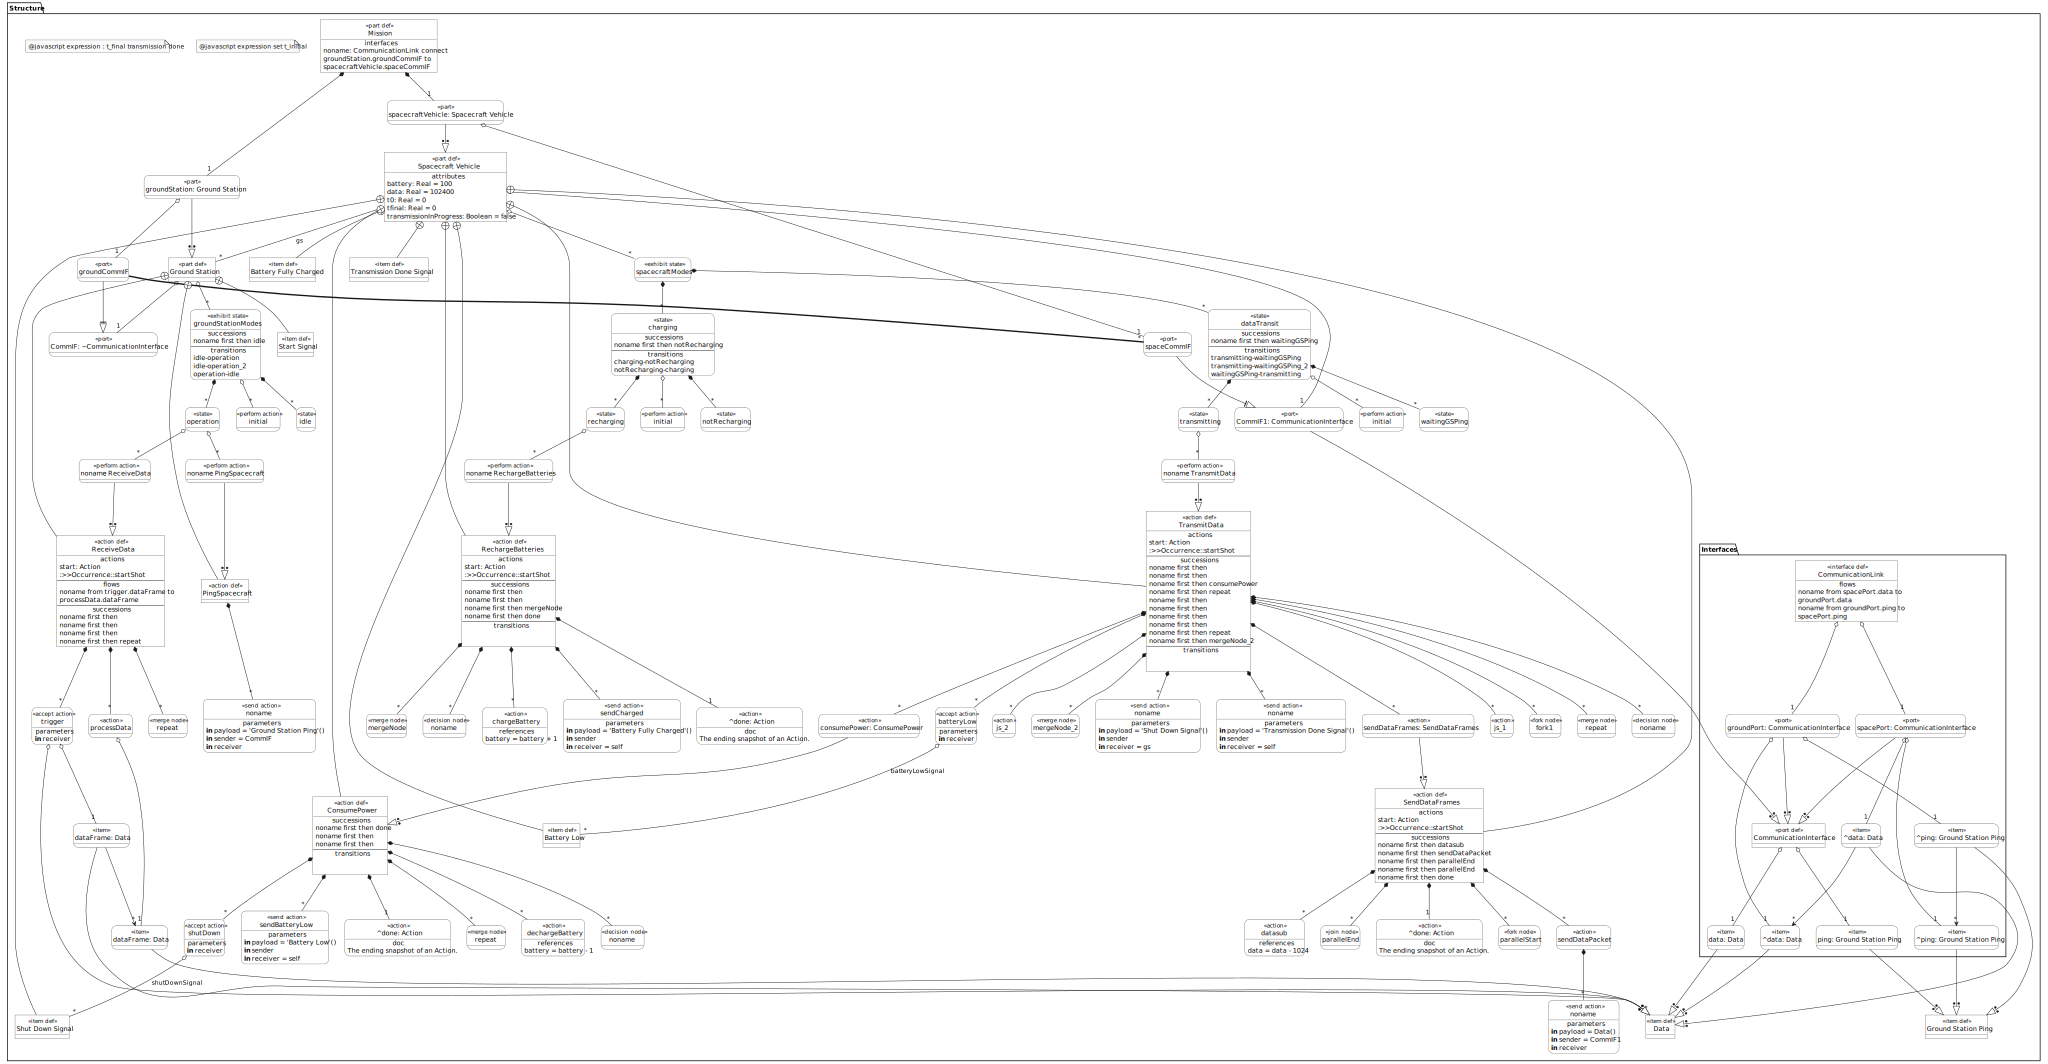

In [3]:
%viz --view=Tree Structure

In [3]:
import scs_sysml.sysml2_lib as lib
lib.displayTreeView(sysml.Structure['Spacecraft Vehicle'])

ERROR:no viable alternative at input '.' (2.sysml line : 1 column : 1)
ERROR:no viable alternative at input '.' (2.sysml line : 1 column : 17)
ERROR:no viable alternative at input 'as' (2.sysml line : 1 column : 29)
ERROR:no viable alternative at input 'lib' (2.sysml line : 2 column : 1)
ERROR:no viable alternative at input '.' (2.sysml line : 2 column : 4)
ERROR:no viable alternative at input '(' (2.sysml line : 2 column : 20)
ERROR:no viable alternative at input '.' (2.sysml line : 2 column : 26)
ERROR:no viable alternative at input ')' (2.sysml line : 2 column : 36)
ERROR:no viable alternative at input ']' (2.sysml line : 2 column : 57)


In [4]:
lib.displayInterconnectionView(sysml.Structure.Mission)

ERROR:no viable alternative at input '.' (3.sysml line : 1 column : 4)
ERROR:no viable alternative at input '(' (3.sysml line : 1 column : 31)
ERROR:no viable alternative at input '.' (3.sysml line : 1 column : 37)
ERROR:no viable alternative at input '.' (3.sysml line : 1 column : 47)
ERROR:no viable alternative at input ')' (3.sysml line : 1 column : 55)


In [5]:
for member in sysml.Structure['Spacecraft Vehicle'].ConsumePower.getOwnedMembers():
    print(member.getName(), member.getSysMLType())

ERROR:missing EOF at 'for' (4.sysml line : 1 column : 1)


In [93]:
for member in sysml.Structure['Spacecraft Vehicle'].spacecraftModes.charging.getOwnedMembers():
    print(member.getName(), member.getSysMLType())

initial PerformActionUsage
ab49b0c3-421e-4c8a-8f06-a5fc9df7896a SuccessionAsUsage
notRecharging StateUsage
notRecharging-charging TransitionUsage
recharging StateUsage
charging-notRecharging TransitionUsage


In [95]:
sysml.Structure['Spacecraft Vehicle'].spacecraftModes.charging.isParallel()

False

In [6]:
sysml.Structure['Spacecraft Vehicle'].spacecraftModes.charging.getEntryAction().getPerformedAction().getName()

ERROR:no viable alternative at input '.' (5.sysml line : 1 column : 6)
ERROR:no viable alternative at input '.' (5.sysml line : 1 column : 16)
ERROR:no viable alternative at input ']' (5.sysml line : 1 column : 37)
ERROR:no viable alternative at input '.' (5.sysml line : 1 column : 54)
ERROR:no viable alternative at input '.' (5.sysml line : 1 column : 63)
ERROR:no viable alternative at input '(' (5.sysml line : 1 column : 78)
ERROR:no viable alternative at input '(' (5.sysml line : 1 column : 99)
ERROR:no viable alternative at input '(' (5.sysml line : 1 column : 109)


In [100]:
for feature in sysml.Structure.Mission.spacecraftVehicle.getAllFeatures():
    print(feature.getName(), feature.getSysMLType())

spaceCommIF PortUsage
gs ReferenceUsage
spacecraftModes ExhibitStateUsage
data AttributeUsage
battery AttributeUsage
transmissionInProgress AttributeUsage
t0 AttributeUsage
tfinal AttributeUsage


In [5]:
sysml.Structure.Mission.spacecraftVehicle.battery.getAttributeValue()

50